In [2]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import mne

In [3]:
# Label sizes
TICK_LABEL_SIZE = 18
AXIS_LABEL_SIZE = 24
TITLE_LABEL_SIZE = 32

In [4]:
# sort dict by keys
def sort_dict(dict):
    return {k: dict[k] for k in sorted(dict.keys())}

In [5]:
DATA_PATH = '/home/williamtheodor/Documents/DL for EEG Classification/data/'
#PARCELLATION = 'aparc.a2009s'
PARCELLATION = 'HCPMMP1_combined'

data = {
    'Delta': sort_dict(delta_activity),
    'Theta': sort_dict(theta_activity),
    'Alpha': sort_dict(alpha_activity),
    'Beta': sort_dict(beta_activity),
    'Gamma': sort_dict(gamma_activity)
}

In [6]:
def compare_electrode_activity(raw_open, raw_closed, title=None):

    fig, ax = plt.subplots(1, 1, figsize=(32, 6))

    bar_width = 0.4

    open_color = 'tomato'
    closed_color = 'lightblue'

    x = np.arange(64)
    ax.bar(x-bar_width/2, (raw_open.get_data()**2).mean(axis=1), color=open_color, width=bar_width)
    ax.bar(x+bar_width/2, (raw_closed.get_data()**2).mean(axis=1), color=closed_color, width=bar_width)

    ax.set_yscale('log')
    ax.margins(0)

    ax.set_xticks(x, raw_open.info['ch_names'], fontsize=14)
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.legend(['OPEN', 'CLOSED'], fontsize=14)
    ax.set_title(title, fontsize=TITLE_LABEL_SIZE)
    plt.show()

def plot_baseline_comparison_patient_level(band_data, patient, title=None, savefig=False):

        # set width of bar
        barWidth = 0.4

        # make plot
        fig, ax = plt.subplots(1, 1, figsize=(32, 6), sharey=True)

        # Set position of bar on X axis
        X = np.arange(band_data[patient][patient+'R01']['T0'].shape[1])
        br1 = [x - barWidth/2 for x in X]
        br2 = [x + barWidth/2 for x in X]

        left_color = 'tomato'
        right_color = 'lightblue'

        open = band_data[patient][patient+'R01']['T0'][0]
        closed = band_data[patient][patient+'R02']['T0'][0]

        total = open + closed

        # Make the plot
        ax.bar(br1, open, color=left_color, width = barWidth,
                edgecolor ='grey', label ='OPEN')
        ax.bar(br2, closed, color=right_color, width = barWidth,
                edgecolor ='grey', label ='CLOSED')

        # Adding ticks
        ax.set_xlabel('Regions', fontsize=AXIS_LABEL_SIZE)
        ax.set_ylabel('Standardised Activity', fontsize=AXIS_LABEL_SIZE)
        #ax.set_xticks(X, label_names, fontsize=TICK_LABEL_SIZE, rotation=90)
        ax.margins(.01)
        ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_SIZE)

        ax.set_title(title, fontsize=TITLE_LABEL_SIZE)

        plt.tight_layout() 
        plt.legend(fontsize=TICK_LABEL_SIZE)

        if savefig:
                plt.savefig('figures/baseline_comparison_patient_level.png', dpi=300)
        plt.show()

def plot_baseline_comparison_patient_level_2(open, closed, title=None, savefig=False):
        # set width of bar
        barWidth = 0.4

        # make plot
        fig, ax = plt.subplots(1, 1, figsize=(32, 6), sharey=True)

        # Set position of bar on X axis
        X = np.arange(open.shape[1])
        br1 = [x - barWidth/2 for x in X]
        br2 = [x + barWidth/2 for x in X]

        left_color = 'tomato'
        right_color = 'lightblue'


        open = open[0]
        closed = closed[0]
        total = open + closed

        # Make the plot
        ax.bar(br1, open, color=left_color, width = barWidth,
                edgecolor ='grey', label ='OPEN')
        ax.bar(br2, closed, color=right_color, width = barWidth,
                edgecolor ='grey', label ='CLOSED')

        # Adding ticks
        ax.set_xlabel('Regions', fontsize=AXIS_LABEL_SIZE)
        ax.set_ylabel('Activity', fontsize=AXIS_LABEL_SIZE)

        subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()
        labels = get_labels(subjects_dir, parcellation_name = "HCPMMP1_combined")
        label_names = [label.name for label in np.array(labels).flatten()]

        ax.set_xticks(X, label_names, fontsize=TICK_LABEL_SIZE, rotation=90)
        ax.margins(.01)
        ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_SIZE)

        ax.set_title(title, fontsize=TITLE_LABEL_SIZE)

        #plt.tight_layout() 
        plt.legend(fontsize=TICK_LABEL_SIZE)

        if savefig:
                plt.savefig('figures/baseline_comparison_patient_level.png', dpi=300)
        plt.show()

In [7]:
def calculate_activity_per_label(annotation_dict, labels, compute_inverse):
    activity = {}

    for anno in annotation_dict.keys():
        activity[anno] = np.empty((len(annotation_dict[anno]), sum(len(hemi) for hemi in labels)))
        for i, window in enumerate(annotation_dict[anno]):
            stc = compute_inverse(window)
            activity[anno][i] = np.concatenate(get_power_per_label(stc, labels, standardize=False))

    return activity

def make_fast_inverse_operator(info, fwd, cov, method="eLORETA", snr=1, nave=1, verbose=False):
    lambda2 = 1/snr**2
    inv = mne.minimum_norm.make_inverse_operator(info, fwd, cov, verbose=verbose)
    inv = mne.minimum_norm.prepare_inverse_operator(inv, nave, lambda2, method=method, verbose=verbose)
    
    func = lambda x: mne.minimum_norm.apply_inverse_raw(x, inv, lambda2, method=method, nave=nave, prepared=True, verbose=verbose)
    return func

def activity_temp(FILE, tmin=0, tmax=10, high_pass=0.5, low_pass=70.0, method="eLORETA", snr=1.0):
    
    subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()
    labels = get_labels(subjects_dir, parcellation_name = "HCPMMP1_combined")

    raw = get_raw(FILE, filter=True, high_pass=high_pass, low_pass=low_pass)
    raw = raw.crop(tmin=tmin, tmax=tmax)

    src = get_src(src_path)
    fwd = get_fwd(raw.info, trans, src_path, bem_path)

    annotations = get_annotations(FILE)
    annotation_dict = get_window_dict(raw, annotations)

    cov = get_cov(raw)
    compute_inverse = make_fast_inverse_operator(raw.info, fwd, cov, method=method, snr=snr)

    activity = calculate_activity_per_label(annotation_dict, labels, compute_inverse)

    return raw, activity

def assess_method(patient, filepath_open, filepath_closed, tmin=0, tmax=10, high_pass=0.5, low_pass=70.0, method="eLORETA"):

    raw_open, activity_open = activity_temp(filepath_open, tmin=tmin, tmax=tmax, high_pass=high_pass, low_pass=low_pass, method=method, snr=50)
    raw_closed, activity_closed = activity_temp(filepath_closed, tmin=tmin, tmax=tmax, high_pass=high_pass, low_pass=low_pass, method=method, snr=50)

    compare_electrode_activity(raw_open, raw_closed, title=f'Channel Activity: Patient {patient}, Interval: {tmin}-{tmax} sec.')
    plot_baseline_comparison_patient_level_2(activity_open['T0'], activity_closed['T0'], title=f'Region Activity: Patient {patient}, Interval: {tmin}-{tmax} sec., Method: {method}')

In [8]:
patient = 'S002'

high_pass = 30.0
low_pass = 70.0

filepath_open = f'../../data/eegmmidb (raw)/files/{patient}/{patient}R01.edf'
raw_open = get_raw(filepath_open, filter=True, high_pass=high_pass, low_pass=low_pass)
#raw_open = raw_open.crop(tmin=0, tmax=10)
psd_open = raw_open.compute_psd()

filepath_closed = f'../../data/eegmmidb (raw)/files/{patient}/{patient}R02.edf'
raw_closed = get_raw(filepath_closed, filter=True, high_pass=high_pass, low_pass=low_pass)
#raw_closed = raw_closed.crop(tmin=0, tmax=10)
psd_closed = raw_closed.compute_psd()

assess_method(patient, filepath_open, filepath_closed, tmin=0, tmax=10, high_pass=high_pass, low_pass=low_pass, method="eLORETA")

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


/home/williamtheodor/.local/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


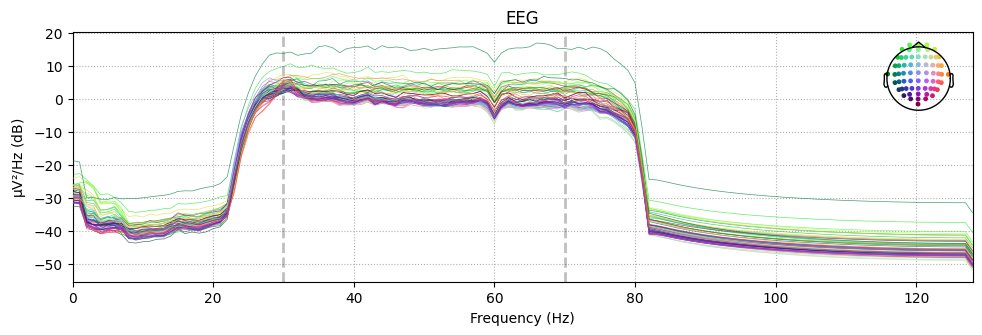

/home/williamtheodor/.local/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


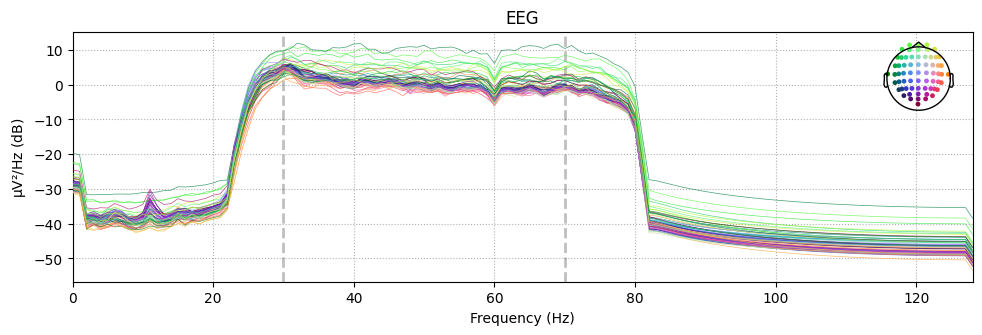

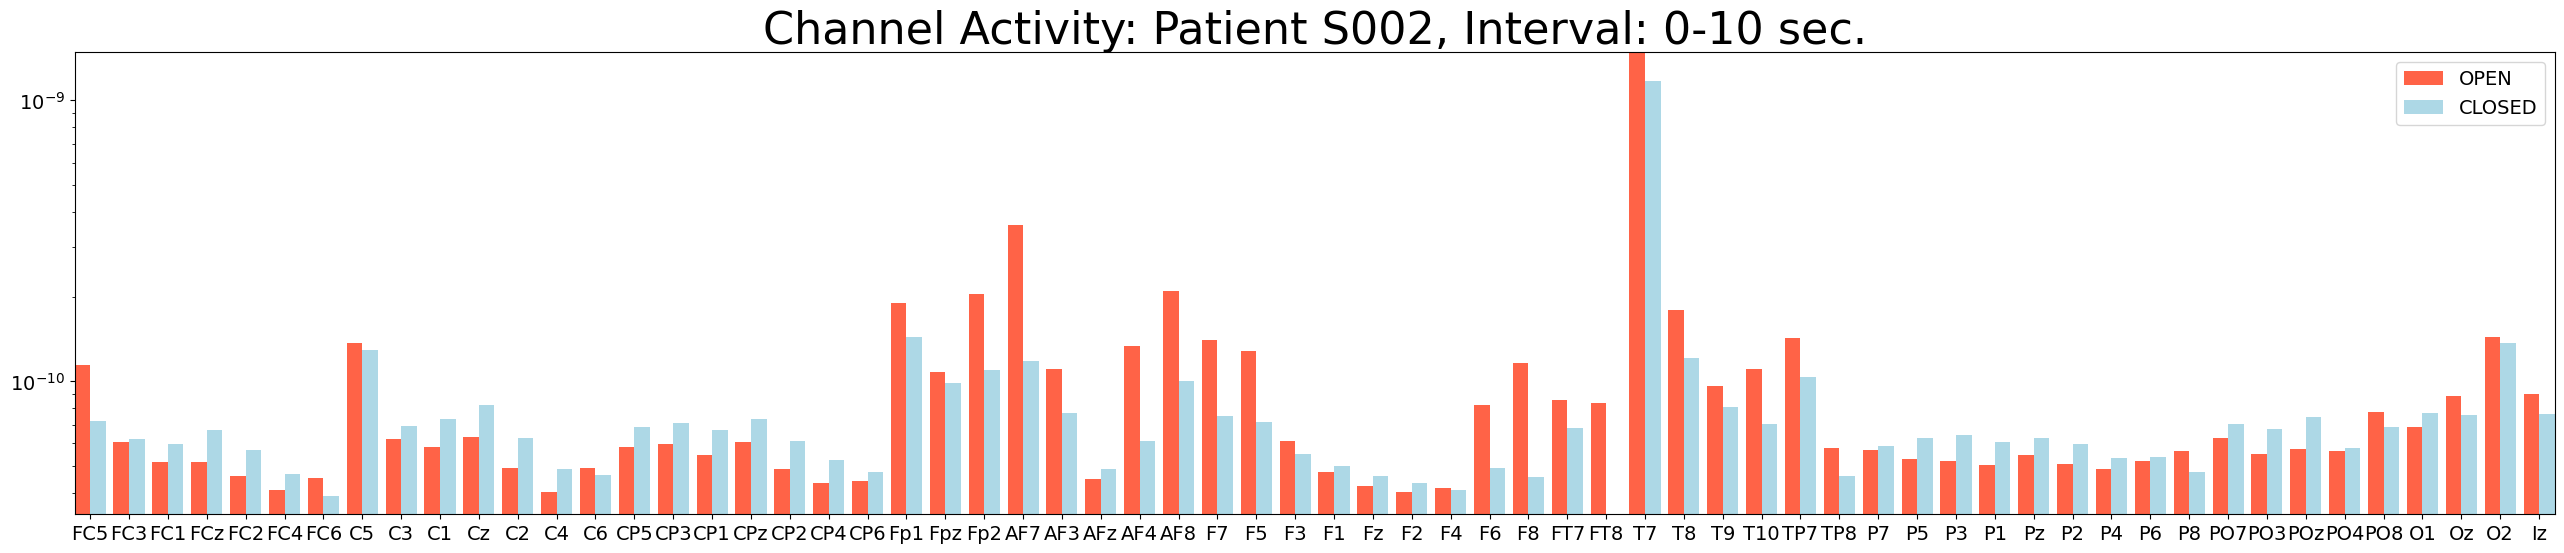

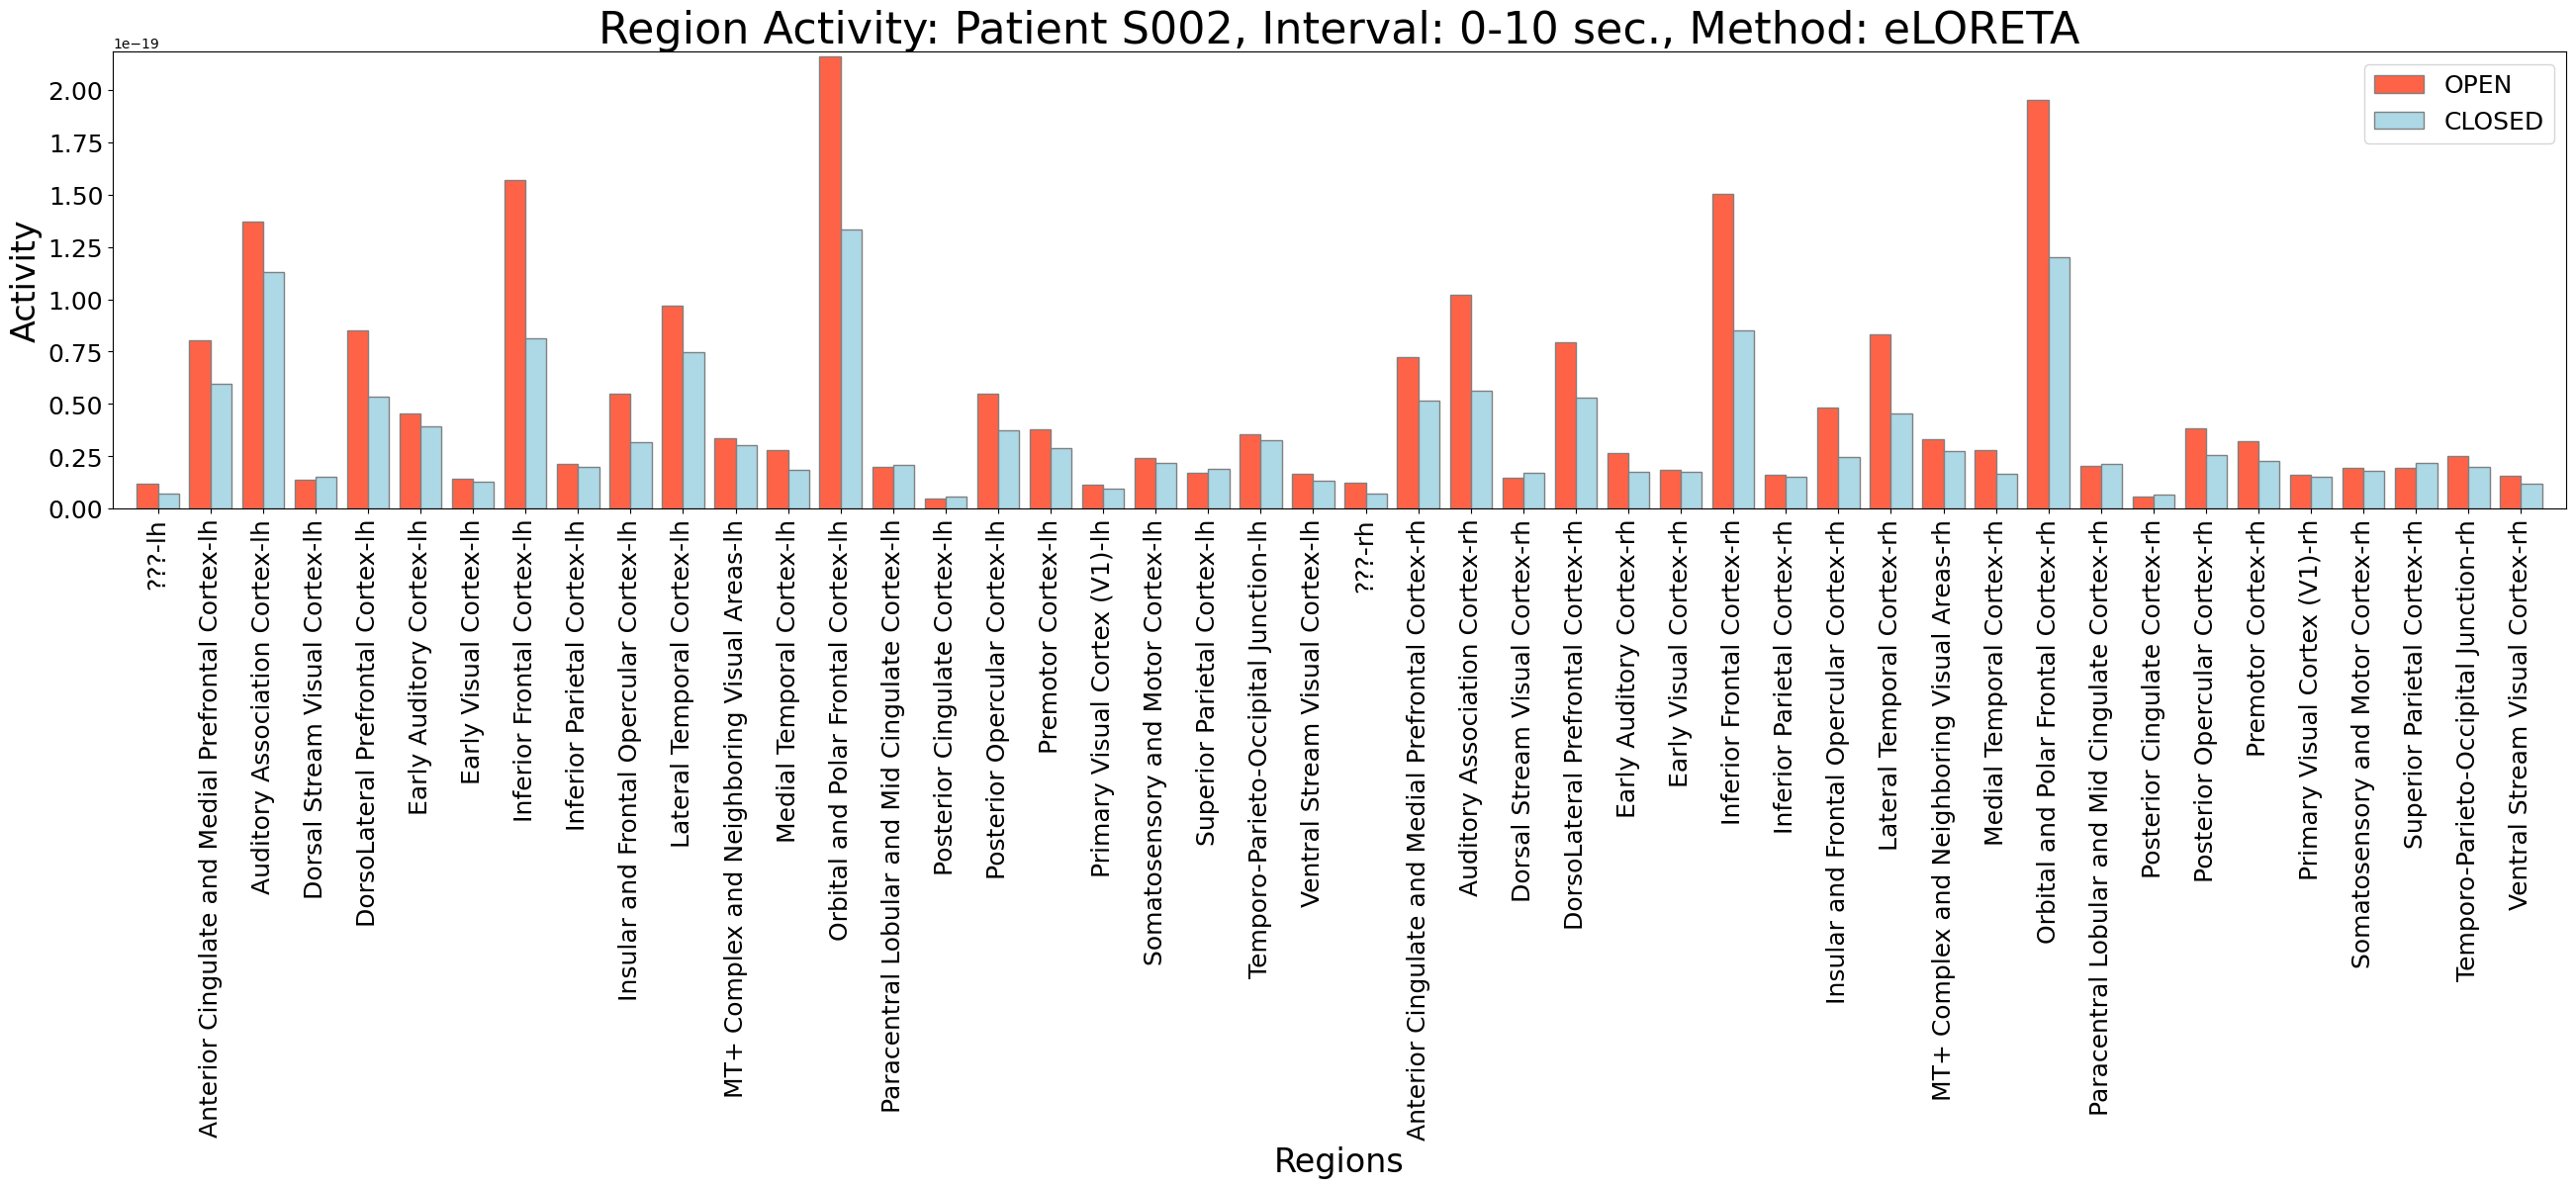

In [10]:
psd_open.plot();
plt.show()
psd_closed.plot();
plt.show()

#compare_electrode_activity(raw_open, raw_closed)
#plot_baseline_comparison_patient_level(data['Alpha'], patient)



Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


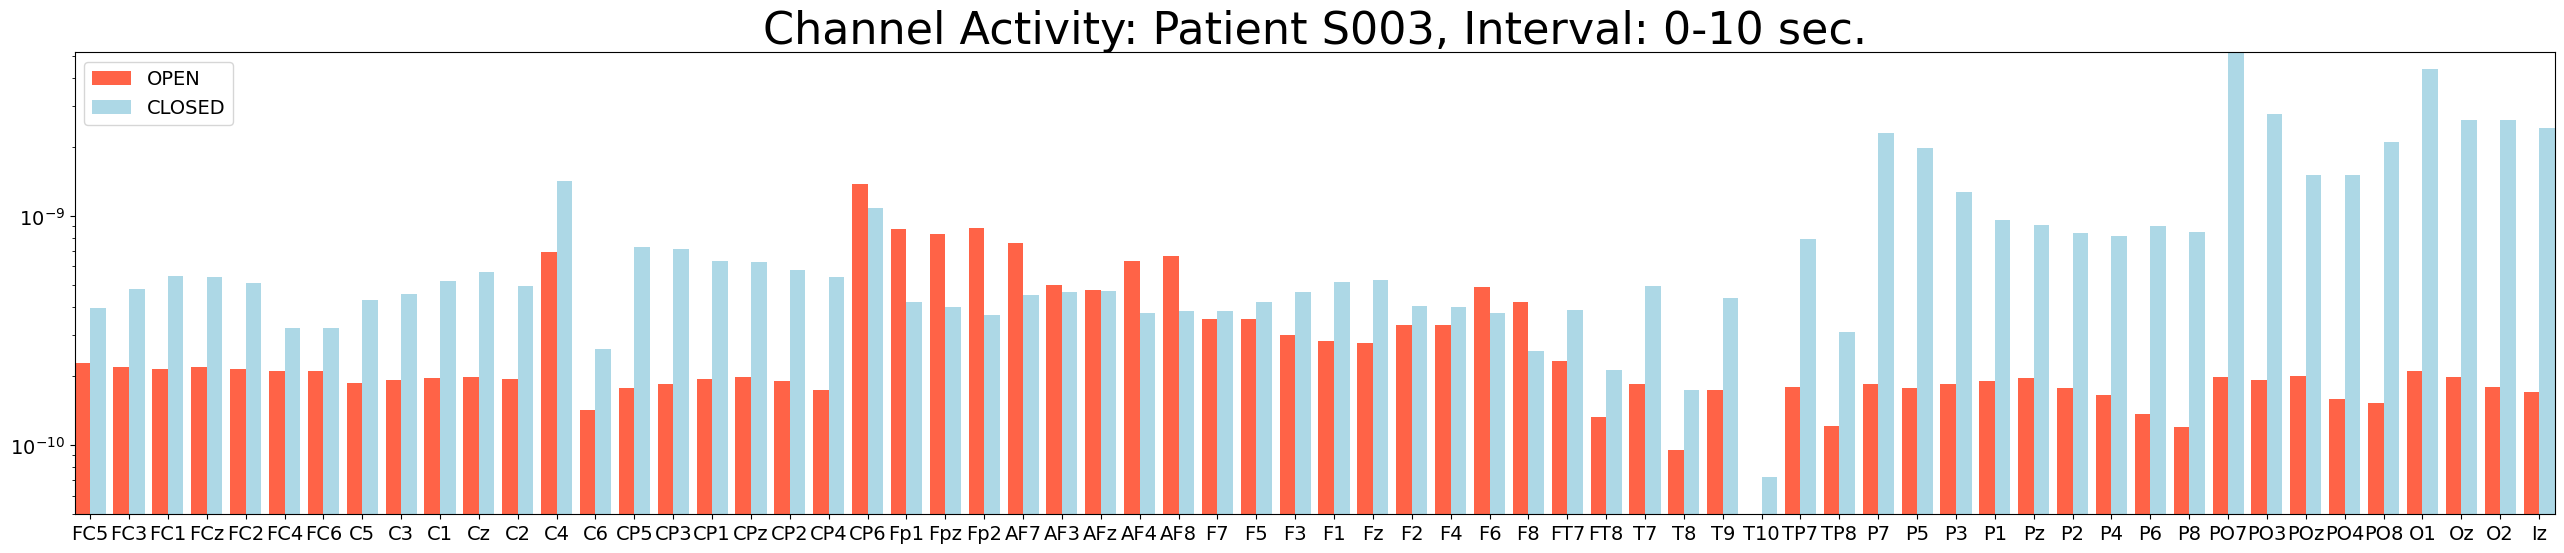

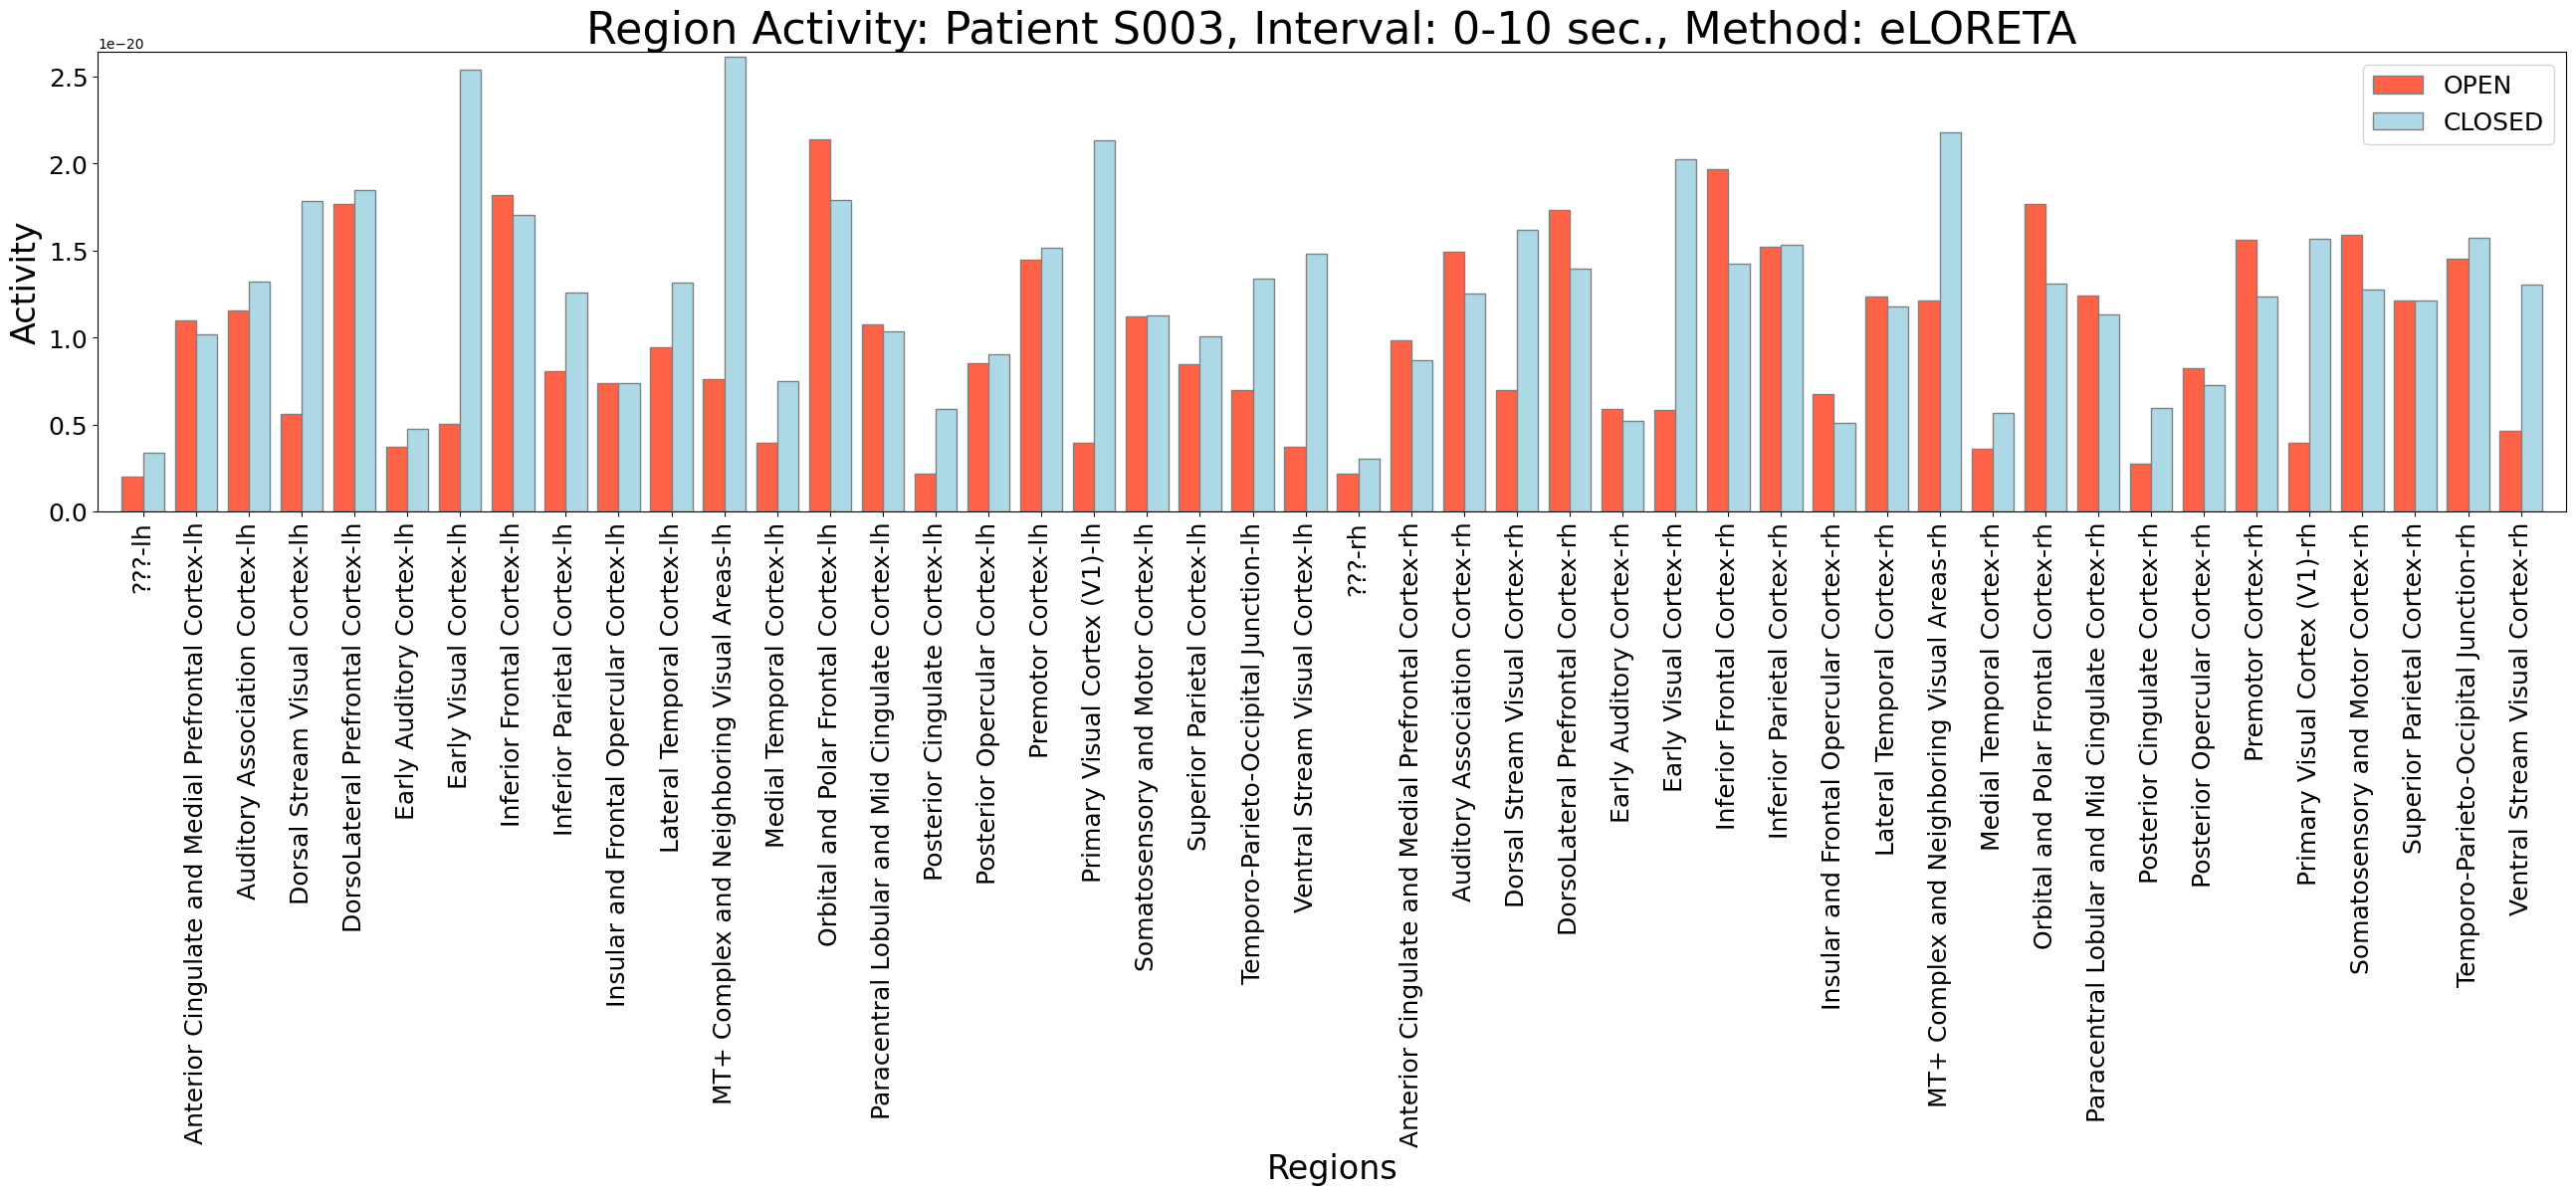

In [11]:
patient = 'S003'

high_pass = 8.0
low_pass = 12.0

filepath_open = f'../../data/eegmmidb (raw)/files/{patient}/{patient}R01.edf'
raw_open = get_raw(filepath_open, filter=True, high_pass=high_pass, low_pass=low_pass)
#raw_open = raw_open.crop(tmin=0, tmax=10)
psd_open = raw_open.compute_psd()

filepath_closed = f'../../data/eegmmidb (raw)/files/{patient}/{patient}R02.edf'
raw_closed = get_raw(filepath_closed, filter=True, high_pass=high_pass, low_pass=low_pass)
#raw_closed = raw_closed.crop(tmin=0, tmax=10)
psd_closed = raw_closed.compute_psd()

assess_method(patient, filepath_open, filepath_closed, tmin=0, tmax=10, high_pass=high_pass, low_pass=low_pass, method="eLORETA")

/home/williamtheodor/.local/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


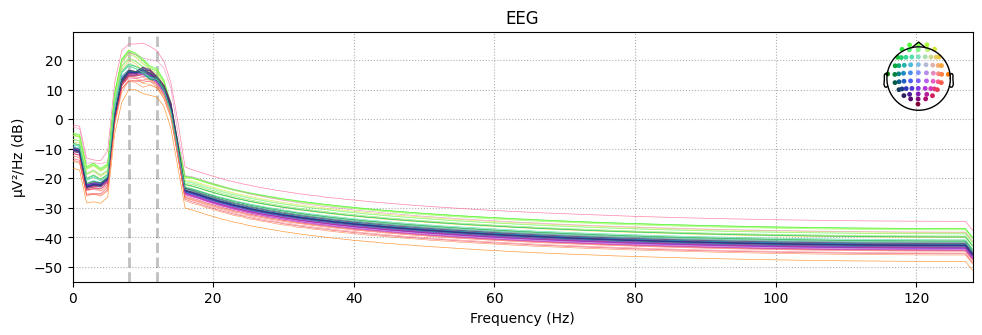

/home/williamtheodor/.local/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


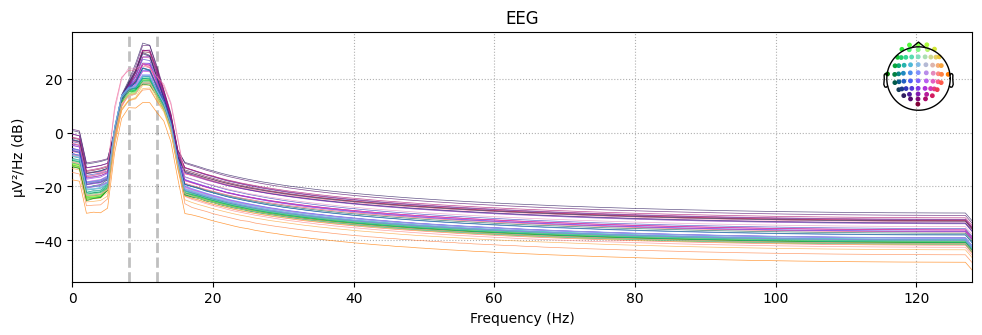

In [18]:
psd_open.plot();
plt.show()
psd_closed.plot();
plt.show()

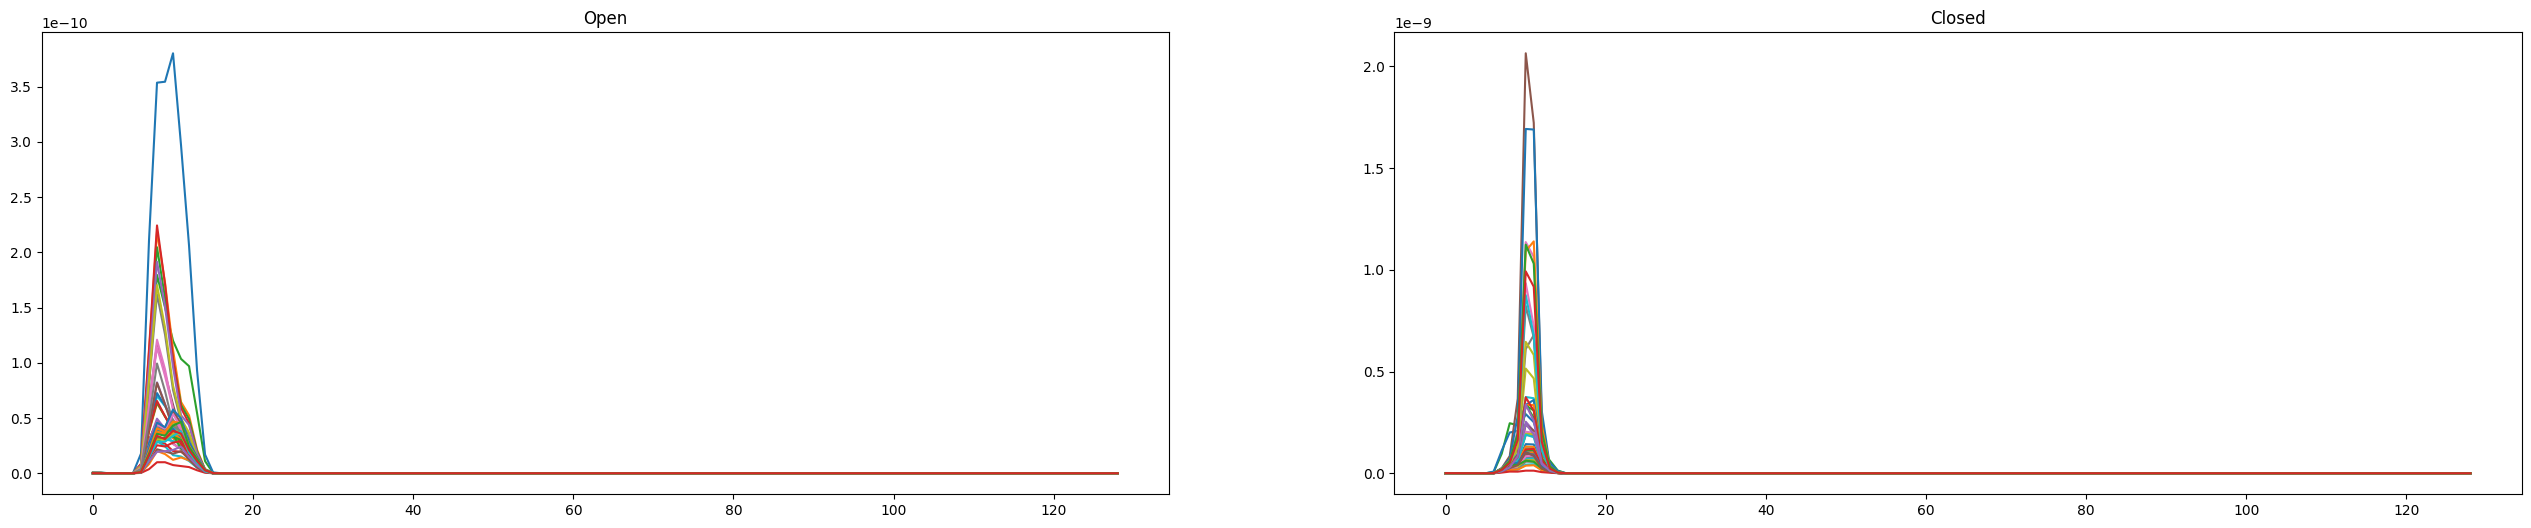

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(32, 6))

ax[0].plot(psd_open.get_data().T)
ax[0].set_title('Open')
ax[1].plot(psd_closed.get_data().T)
ax[1].set_title('Closed')
plt.show()